In [1]:
from inverse_certain import run_with_params, INVERSE_PARAM_GRID, exhaustive_search, INVERSE_PIPE
from materials import TRAIN_DATA
from sklearn.model_selection import ParameterGrid

params = list(ParameterGrid(INVERSE_PARAM_GRID))

r, p, c = exhaustive_search(
    TRAIN_DATA[["p11", "p22", "p12"]],
    TRAIN_DATA[["angle", "ratio", "p_matrix", "p_fiber"]],
)

(r,p,c)

Params:{'preprocessing': PCA(), 'preprocessing__n_components': 2, 'regressor': LinearRegression()}
Split0: Train done in 0.0851 seconds.	Prediction done in 0.0015 seconds.	Mean certain 0.789.	
Split1: Train done in 0.0585 seconds.	Prediction done in 0.0013 seconds.	Mean certain 0.791.	
Split2: Train done in 0.0593 seconds.	Prediction done in 0.0018 seconds.	Mean certain 0.784.	
Split3: Train done in 0.0614 seconds.	Prediction done in 0.0013 seconds.	Mean certain 0.788.	
Split4: Train done in 0.0612 seconds.	Prediction done in 0.0017 seconds.	Mean certain 0.789.	

Params:{'preprocessing': PCA(n_components=2), 'preprocessing__n_components': 2, 'regressor': DecisionTreeRegressor()}
Split0: Train done in 0.5985 seconds.	Prediction done in 0.0093 seconds.	Mean certain 0.992.	
Split1: Train done in 0.6048 seconds.	Prediction done in 0.0099 seconds.	Mean certain 0.992.	
Split2: Train done in 0.6110 seconds.	Prediction done in 0.0098 seconds.	Mean certain 0.992.	
Split3: Train done in 0.6359 s

([{'params': {'preprocessing': PCA(n_components=3),
    'preprocessing__n_components': 2,
    'regressor': LinearRegression()},
   'results': {'splits': [{'x_train': array([[ 2.61964753e+02,  2.63583417e+02, -9.64524350e-01],
             [ 1.90495054e+02,  1.91959868e+02, -8.72848507e-01],
             [ 5.75905665e+01,  5.75647796e+01,  3.54245315e-02],
             ...,
             [ 6.54180206e+01,  7.16866683e+01, -3.13432383e+00],
             [ 1.21806209e+02,  1.23054026e+02, -7.43545279e-01],
             [ 2.16940169e+02,  2.16938441e+02,  3.22378686e-03]]),
      'y_train': array([[5.00e+01, 3.30e-01, 2.05e+02, 4.50e+02],
             [5.00e+01, 2.60e-01, 1.45e+02, 4.70e+02],
             [7.00e+01, 1.40e-01, 6.70e+01, 2.00e+01],
             ...,
             [4.50e+01, 4.00e-01, 3.50e+01, 3.10e+02],
             [5.00e+01, 2.70e-01, 8.90e+01, 3.40e+02],
             [7.50e+01, 1.40e-01, 2.12e+02, 2.50e+02]]),
      'x_test': array([[ 4.96258303e+01,  6.78929666e+01, -9.13

In [3]:
INVERSE_PIPE.set_params(**p)

INVERSE_PIPE.fit(
    TRAIN_DATA[["p11", "p22", "p12"]],
    TRAIN_DATA[["angle", "ratio", "p_matrix", "p_fiber"]],
)

Pipeline(steps=[('scaling', StandardScaler()),
                ('preprocessing',
                 FunctionTransformer(func=<function <lambda> at 0x7f5ebb636a20>)),
                ('regressor', KNeighborsRegressor(n_neighbors=1))])

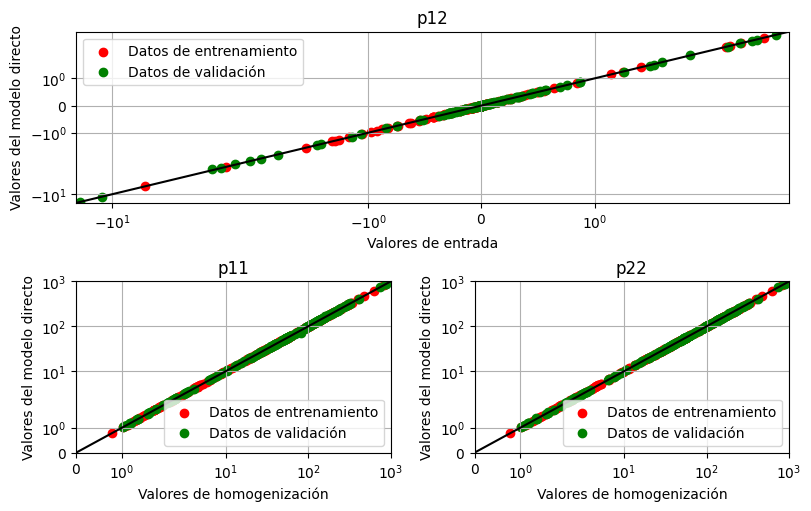

In [10]:
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from materials import GLOBAL_DATA, VALIDATION_DATA
from direct import DIRECT_GRID_SILENT

_, TRAIN_SAMPLES = train_test_split(TRAIN_DATA, test_size=200, random_state=16)
# TRAIN_SAMPLES=TRAIN_DATA

_, VALIDATION_SAMPLES = train_test_split(
    VALIDATION_DATA, test_size=200, random_state=16
)
direct_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("preprocessing", FastICA(4)),
        ("regressor", KNeighborsRegressor(4, weights="distance")),
    ]
)

direct_pipe.fit(
    GLOBAL_DATA[["angle", "ratio", "p_matrix", "p_fiber"]].to_numpy(),
    GLOBAL_DATA[["p11", "p22", "p12"]].to_numpy(),
)
# VALIDATION_SAMPLES=VALIDATION_DATA

# Draw graph with comparison of predicted vs AHM values for train and validation data
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5), layout="constrained")

graph_p12 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
graph_p12.grid(True)
graph_p12.set_xscale(
    "symlog",
)
graph_p12.set_yscale(
    "symlog",
)

graph_p11 = plt.subplot2grid((2, 2), (1, 0))
graph_p11.grid(True)
graph_p11.set_xscale(
    "symlog",
)
graph_p11.set_yscale(
    "symlog",
)

graph_p22 = plt.subplot2grid((2, 2), (1, 1))
graph_p22.grid(True)
graph_p22.set_xscale(
    "symlog",
)
graph_p22.set_yscale(
    "symlog",
)


x_train, y_train = (TRAIN_SAMPLES), (
    direct_pipe.predict(INVERSE_PIPE.predict(TRAIN_SAMPLES[["p11", "p22", "p12"]]))
)

x_validation, y_validation = (VALIDATION_SAMPLES), (
    direct_pipe.predict(INVERSE_PIPE.predict(VALIDATION_SAMPLES[["p11", "p22", "p12"]]))
)

graph_p12.scatter(
    x_train["p12"],
    y_train[:, 2],
    color="red",
    label="Datos de entrenamiento",
)
graph_p12.scatter(
    x_validation["p12"],
    y_validation[:, 2],
    color="green",
    label="Datos de validación",
)

# Plot a line for the 1:1 relationship
graph_p12.plot([-15, 5], [-15, 5], color="black")

# Limit x and y to the range between -40 and 10
graph_p12.set_xlim([-15, 5])
graph_p12.set_ylim([-15, 5])

graph_p11.scatter(
    x_train["p11"],
    y_train[:, 0],
    color="red",
    label="Datos de entrenamiento",
)
graph_p11.scatter(
    x_validation["p11"],
    y_validation[:, 0],
    color="green",
    label="Datos de validación",
)

# Plot a line for the 1:1 relationship
graph_p11.plot([0, 1000], [0, 1000], color="black")

# Limit x and y to the range between 0 and 1000
graph_p11.set_xlim([0, 1000])
graph_p11.set_ylim([0, 1000])

graph_p22.scatter(
    x_train["p22"],
    y_train[:, 1],
    color="red",
    label="Datos de entrenamiento",
)
graph_p22.scatter(
    x_validation["p22"],
    y_validation[:, 1],
    color="green",
    label="Datos de validación",
)

# Plot a line for the 1:1 relationship
graph_p22.plot([0, 1000], [0, 1000], color="black")

# Limit x and y to the range between 0 and 1000
graph_p22.set_xlim([0, 1000])
graph_p22.set_ylim([0, 1000])

plt.title(
    "Valores de entrada contra la aproximación del modelo directo sobre los valores de salida"
)

graph_p12.set_xlabel("Valores de entrada")
graph_p12.set_ylabel("Valores del modelo directo")
graph_p12.set_title("p12")

graph_p11.set_xlabel("Valores de homogenización")
graph_p11.set_ylabel("Valores del modelo directo")
graph_p11.set_title("p11")

graph_p22.set_xlabel("Valores de homogenización")
graph_p22.set_ylabel("Valores del modelo directo")
graph_p22.set_title("p22")

graph_p12.legend()
graph_p11.legend()
graph_p22.legend()

plt.show()